In [1]:
from deepchem.feat import MolGraphConvFeaturizer
import os
import deepchem as dc
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from deepchem.models import GATModel
from deepchem.feat import ConvMolFeaturizer
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import random
import numpy as np
import torch
import optuna
from optuna.study import create_study
from optuna.storages import RDBStorage
import os

checkpoints_dir = "checkpoints"
os.makedirs(checkpoints_dir, exist_ok=True)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(1234)

#读取EXCEL文件并转换为DataFrame
excel_file = 'DATA/TOP1.xlsx'
data = pd.read_excel(excel_file)
unique_data = data.drop_duplicates(subset='Smiles')

# 获取去重后的SMILES和属性列表
smiles = unique_data['Smiles'].tolist()
properties = unique_data['pIC50'].tolist()

# 创建DeepChem数据集
data_list = []
for s, p in zip(smiles, properties):
    mol = Chem.MolFromSmiles(s)
    logP = Descriptors.MolLogP(mol)
    mw = Descriptors.MolWt(mol)
    tpsa = Descriptors.TPSA(mol)
    volume = mw / (1.2 * Descriptors.MolMR(mol))
    featurized_mol = MolGraphConvFeaturizer().featurize([mol])[0]
    num_atoms = featurized_mol.node_features.shape[0]
    node_features = np.zeros((num_atoms, 4))
    node_features[:, 0] = logP
    node_features[:, 1] = mw
    node_features[:, 2] = tpsa
    node_features[:, 3] = volume
    data_list.append((featurized_mol, p))
    
      
X, y = zip(*data_list)
dataset = dc.data.NumpyDataset(X, y)

# 数据集拆分
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=42)

# 正则化因子
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)
train_dataset = transformer.transform(train_dataset)
valid_dataset = transformer.transform(valid_dataset)
test_dataset = transformer.transform(test_dataset)

# 设置模型参数
n_tasks = 1
learning_rate = 4e-3
weight_decay = 1e-5
n_epochs = 200
batch_size = 128

# 模型评估
def evaluate(model, dataset, transformer):
    metrics = [dc.metrics.Metric(dc.metrics.rms_score, mode="regression"), 
               dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")]  
    transformers = [transformer] if not isinstance(transformer, list) else transformer
    transformers = [t for t in transformers if hasattr(t, 'transform_y') and t.transform_y]
    scores = model.evaluate(dataset, metrics, transformers)
    return scores
best_params = {'learning_rate': 0.00032393330218344715, 'weight_decay': 0.00023954090059427396, 'n_epochs': 372, 'batch_size': 256, 'predictor_hidden_feats': 256, 'predictor_dropout': 0.11567709904010375}
best_model = GATModel(
    mode='regression',
    n_tasks=n_tasks,
    n_classes=1,
    weight_decay=best_params["weight_decay"],
    batch_size=int(best_params["batch_size"]),
    learning_rate=best_params["learning_rate"],
    predictor_hidden_feats=int(best_params["predictor_hidden_feats"]),
    graph_attention_layers=[8, 8, 8 ,8 ],
    predictor_dropout=best_params["predictor_dropout"],
    agg_modes=['mean', 'mean', 'mean', 'flatten']
)





RDKit WARNING: [10:25:20] Enabling RDKit 2019.09.1 jupyter extensions
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
/home/szy/anaconda3/envs/qsar_gpu/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
best_model.model.load_state_dict(torch.load('checkpoint/best_model_original_TOP1_3.pt'))



<All keys matched successfully>

In [3]:
predictions = best_model.predict(test_dataset)
untransformed_predictions = transformer.untransform(predictions)

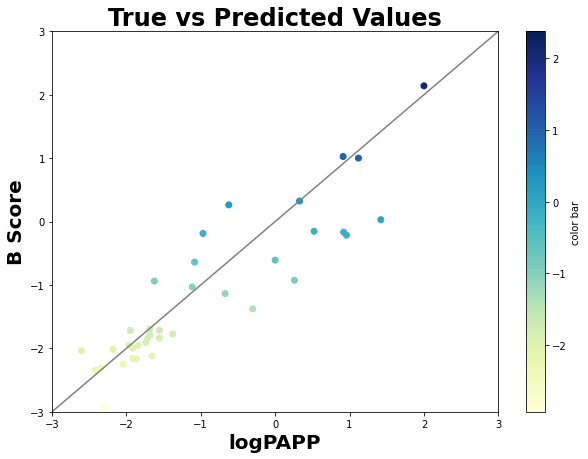

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# plt.rcParams['font.size'] = 20
# plt.rcParams['font.weight'] = 'bold'
# Generate predictions and untransform
predictions = best_model.predict(valid_dataset)
untransformed_predictions = transformer.untransform(predictions)
# untransformed_predictions +=7
# Extract the true values from the test set and untransform
true_values = valid_dataset.y
untransformed_true_values = transformer.untransform(true_values)
untransformed_true_values +=-6
untransformed_predictions +=-6
# Create a scatter plot with color indicating the magnitude of the predicted value
cmap = plt.get_cmap('YlGnBu')  # Get the colormap
norm = plt.Normalize(untransformed_predictions.min(), untransformed_predictions.max())  # Normalize the predicted values

# # Extract the true values from the test set and untransform
# true_values = test_dataset.y
# untransformed_true_values = transformer.untransform(true_values)


plt.figure(figsize=(10, 7))
plt.scatter(untransformed_true_values, untransformed_predictions, alpha=1, c=untransformed_predictions.squeeze(), cmap=cmap, norm=norm)
plt.plot([-3, 3], [-3, 3], color='gray')  # A red line that represents perfect prediction
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('logPAPP', fontsize=20, fontweight='bold')
plt.ylabel('B Score', fontsize=20, fontweight='bold')
plt.title('True vs Predicted Values', fontsize=24, fontweight='bold')
plt.colorbar(label='color bar')  # Add a colorbar
# plt.show()
plt.savefig('figure1',dpi=600)

In [5]:
import pandas as pd
from rdkit import Chem
from deepchem.feat import MolGraphConvFeaturizer

# Load the Excel file
input_excel_file = 'TOP1.xlsx'
input_data = pd.read_excel(input_excel_file)

# Extract SMILES from the input_data DataFrame
input_smiles = input_data['Smiles'].tolist()

# Featurize the input molecules
input_mols = [Chem.MolFromSmiles(s) for s in input_smiles]
input_features = MolGraphConvFeaturizer().featurize(input_mols)

# Create a DeepChem dataset from the input features
input_dataset = dc.data.NumpyDataset(input_features)


# Predict the output for the input dataset
input_predictions = best_model.predict(input_dataset)

# Apply inverse transformation to obtain the original scale of the properties
input_predictions_original_scale = transformer.untransform(input_predictions)

input_predictions_original_scale+=-6

# Create a new DataFrame to store the predictions
output_data = input_data.copy()
output_data['Predicted_Properties'] = input_predictions_original_scale.flatten()

# Save the output_data DataFrame to a new Excel file
output_excel_file = 'Testdata_prediction.xlsx'
output_data.to_excel(output_excel_file, index=False)

# 对新分子进行预测的例子
# # smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  # 示例分子，您可以将此替换为您感兴趣的分子的SMILES表示
# mol = Chem.MolFromSmiles(smiles)
# featurized_mol = MolGraphConvFeaturizer().featurize([mol])[0]
# X_new = [featurized_mol]
# new_dataset = dc.data.NumpyDataset(X_new)

# # 使用训练好的模型进行预测
# predictions = best_model.predict(new_dataset)
# predictions = transformer.untransform(predictions)  # 反向转换以获取原始预测值
# print(f"Predicted property for {smiles}: {predictions[0][0]}")
